# <center>Organizaci&oacute;n de Datos</center>
## <center>Trabajo Práctico 2: Criticas de cine</center>

#### Integrantes grupo 19: Sudanalytics 
* Adrian Leandro Re
* Alan Toulouse
* Luciano Lorenzo
* Nicolas Tonizzo

Importamos las librerias y modulos necesarios.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from langdetect import detect
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

Cargamos nuestro set de entrenamiento.

In [2]:
df = pd.read_csv("dataset/train.csv")
df.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Feature Engineering

Primero verificamos que no haya ningun valor nulo en nuestro dataframe, ya que no tendria sentido hacer el analisis de sentimientos a partir de una review vacía.

In [7]:
df['review_es'].isnull().sum()

0

Encodeamos el target para que las review positivas esten representadas por un 1 y las negativas por 0.

In [8]:
df['sentimiento_es_positivo'] = np.where(df.sentimiento == 'positivo', 1, 0)

Nos aseguramos de que todas las reviews estén en español, por lo que usaremos la funcion 'detect' de la libreria langdetect y eliminamos todas las que tengan un lenguaje distinto al español.

In [9]:
df = df[df['review_es'].apply(detect) == 'es']

Haremos una copia porque el método Bayes Naive va a usar su propio preprocesamiento.

In [10]:
df_original = df.copy()
df_original.to_csv('dataset/train-spanish.csv')

Seguimos con el preprocesamiento de nuestro set. Pasamos todos los caracteres a minúscula para que sea más fácil preporcesarlos.

In [7]:
df['review_es'] = df['review_es'].str.lower()

Quitamos los acentos de todas las palabras y reemplazamos el caracter ñ por n.

In [8]:
caracteres_especiales = {'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u', 'ñ':'n'}
for original, nuevo in caracteres_especiales.items():
    df['review_es'] = df['review_es'].str.replace(original, nuevo, regex=True)

Removemos todo caracter que no sean letras (números, puntos, comas, comillas, etc.) y los espacios dobles que puedan llegar a aparecer con esta operación.

In [9]:
df['review_es'] = df['review_es'].str.replace('[^a-zA-Z]', ' ', regex=True)
df['review_es'] = df['review_es'].str.replace('  ', ' ', regex=True)

Como último paso para el preprocesamiento, eliminamos las stopwords

In [10]:
from nltk.corpus import stopwords
palabras = '|'.join(stopwords.words('spanish'))
df['review_es'] = df['review_es'].str.replace(fr'\b({palabras})\b', '',regex=True)

Nuestro dataset preprocesado queda de la siguiente manera:

In [11]:
df.head(15)

,ID,review_es,sentimiento,sentimiento_es_positivo
0,0,criticos mencionado despues ver solo o...,positivo,1
1,1,pequena pequena produccion tecnica filmacio...,positivo,1
2,2,pense manera maravillosa pasar tiempo f...,positivo,1
3,3,basicamente familia nino pequeno jake pien...,negativo,0
4,4,amor tiempo petter mattei pelicula visua...,positivo,1
5,5,probablemente pelicula favorita tiempos h...,positivo,1
6,6,seguro gustaria ver resurreccion serie s...,positivo,1
7,7,espectaculo idea increible fresca innovado...,negativo,0
8,8,alentados comentarios positivos pelicula a...,negativo,0
9,9,si gusta risa original desgarradora gustara...,positivo,1


Para evitar hacer este proceso cada vez que se inicie la notebook, guardamos el dataframe preprocesado en un archivo y lo inicializaremos con otra celda

In [18]:
df.to_csv('dataset/train-preprocesado.csv')

In [47]:
df = pd.read_csv("dataset/train-preprocesado.csv")
df_original = pd.read_csv('dataset/train-spanish.csv')

## Sets de test y train
Dividimos el dataframe en datos de test y train. Usaremos estos mismos sets para el entrenamiento de todos los modelos.

In [48]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

X = df_original.review_es
y = df_original.sentimiento_es_positivo
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=19)

## Ensamblado de modelos

### Bayes Naive
Primero transformamos nuestros documentos en una matriz en la cual se almacena la cantidad de tokens ("palabras clave"). Luego convertimos esa misma matriz en una representación normalizada de término/frecuencia. Todo este proceso tiene su propio preproecsamiento de texto por lo que vamos a usar el set original de datos
Esto lo hacemos para reducir el impacto de los tokens que aparecen más veces.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

vectorizador = CountVectorizer()
X_train_counts = vectorizador.fit_transform(X_train_original)

escaladorTfidf = TfidfTransformer()
X_train_tfidf = escaladorTfidf.fit_transform(X_train_counts)

print(X_train_tfidf)

  (0, 127868)	0.16430370020528912
  (0, 127670)	0.10235631413923409
  (0, 127175)	0.03865897305163224
  (0, 126904)	0.13304553149580314
  (0, 126468)	0.08039993529256398
  (0, 126062)	0.1530265840958789
  (0, 124760)	0.12081045826381752
  (0, 122413)	0.09996614514133537
  (0, 122321)	0.10589231546652678
  (0, 121965)	0.05941522481860774
  (0, 120645)	0.07638675892268072
  (0, 117290)	0.10890317660218596
  (0, 117282)	0.07817516035086298
  (0, 114170)	0.03651447709310181
  (0, 112899)	0.10994643463348022
  (0, 111789)	0.08999195507056124
  (0, 110338)	0.07660492399885514
  (0, 101300)	0.15053141992285166
  (0, 100694)	0.040992864246214
  (0, 98610)	0.1046113192762968
  (0, 98363)	0.06517517910162403
  (0, 96358)	0.16982309070417823
  (0, 96348)	0.1289914123288497
  (0, 96236)	0.12204205083872885
  (0, 96078)	0.15412320997732887
  :	:
  (38543, 111705)	0.11068937125032957
  (38543, 105182)	0.1487415864256591
  (38543, 102945)	0.1724948714805163
  (38543, 100658)	0.17301301152384527
  (38

Ahora que tenemos la información en el formato correcto, creamos nuestro modelo de tipo Bayes Naive. En este caso usamos uno de tipo multinomial.

In [27]:
clasificadorBayesNaive = MultinomialNB()
clasificadorBayesNaive.fit(X_train_tfidf, y_train_original)

MultinomialNB()

Realizamos el mismo procedimiento para transformar los datos de validación y poder realizar nuestras predicciones.

In [28]:
X_test_counts = vectorizador.transform(X_test_original)
X_test_tfidf = escaladorTfidf.transform(X_test_counts)
y_pred_original = np.where(clasificadorBayesNaive.predict(X_test_tfidf) >= 0.5, 1, 0)

Construimos nuestra matriz de confusión y analizamos métricas

Text(0.5, 1.0, 'Confusion matrix de validación')

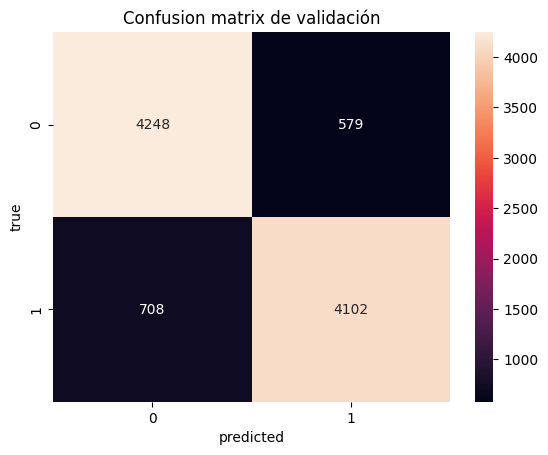

In [30]:
confusion = confusion_matrix(y_test, y_pred_original)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

In [32]:
print("Accuracy:", accuracy_score(y_test_original, y_pred_original))
print("Precision:", precision_score(y_test_original, y_pred_original))
print("Recall:", recall_score(y_test_original, y_pred_original))
print("F1-score:", f1_score(y_test_original, y_pred_original))

Accuracy: 0.8664522154197364
Precision: 0.8763084810937833
Recall: 0.8528066528066528
F1-score: 0.8643978505953007


### Cross validation naive bayes

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [37]:
clf_naive_bayes = MultinomialNB(fit_prior=False)

params_grid2 = {
    "alpha": np.linspace(0.3,1,40),
}

kfoldcv = StratifiedKFold(n_splits=6)

model = GridSearchCV (
    estimator=clf_naive_bayes,
    param_grid=params_grid2,
    scoring=make_scorer(f1_score),
    cv=kfoldcv,
)

model.fit(X_train_tfidf, y_train_original)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=MultinomialNB(fit_prior=False),
             param_grid={'alpha': array([0.3       , 0.31794872, 0.33589744, 0.35384615, 0.37179487,
       0.38974359, 0.40769231, 0.42564103, 0.44358974, 0.46153846,
       0.47948718, 0.4974359 , 0.51538462, 0.53333333, 0.55128205,
       0.56923077, 0.58717949, 0.60512821, 0.62307692, 0.64102564,
       0.65897436, 0.67692308, 0.69487179, 0.71282051, 0.73076923,
       0.74871795, 0.76666667, 0.78461538, 0.8025641 , 0.82051282,
       0.83846154, 0.85641026, 0.87435897, 0.89230769, 0.91025641,
       0.92820513, 0.94615385, 0.96410256, 0.98205128, 1.        ])},
             scoring=make_scorer(f1_score))

In [38]:
print("Los mejores parametros encontrados son: ", model.best_params_)
print("con un f1 score: ", model.best_score_)

Los mejores parametros encontrados son:  {'alpha': 0.964102564102564}
con un f1 score:  0.8598276344507401


In [39]:
pd.DataFrame(model.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
37,0.035657,0.000356,0.007655,0.000108,0.964103,{'alpha': 0.964102564102564},0.870028,0.857504,0.859159,0.856509,0.864431,0.851334,0.859828,0.005975,1
36,0.037050,0.002015,0.007574,0.000470,0.946154,{'alpha': 0.9461538461538461},0.869892,0.857910,0.858890,0.856690,0.864116,0.851152,0.859775,0.005907,2
35,0.038051,0.001013,0.007866,0.000300,0.928205,{'alpha': 0.9282051282051282},0.869973,0.857594,0.858934,0.856057,0.863937,0.851287,0.859630,0.005952,3
38,0.046652,0.012878,0.009236,0.002726,0.982051,{'alpha': 0.9820512820512819},0.870069,0.857504,0.858980,0.856283,0.864209,0.850699,0.859624,0.006135,4
39,0.058859,0.015902,0.010985,0.003273,1.0,{'alpha': 1.0},0.870028,0.857775,0.858622,0.855966,0.864030,0.851064,0.859581,0.006038,5


In [40]:
X_test_counts = vectorizador.transform(X_test_original)
X_test_tfidf = escaladorTfidf.transform(X_test_counts)
y_pred = np.where(model.predict(X_test_tfidf) >= 0.5, 1, 0)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8668672823492788
Precision: 0.8759326369643999
Recall: 0.8542619542619543
F1-score: 0.8649615829912641


Creamos submit para competencia Kaggle

In [41]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(model.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

Guardamos el model para ser usado mas tarde en el ensamble

In [42]:
with open('modelos/BayesNaiveCV.pickle', 'wb') as file:
    pickle.dump(model, file)

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [32]:
X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=19)
vectorizador = CountVectorizer()
escaladorTfidf = TfidfTransformer()
X_train_counts_2 = vectorizador.fit_transform(X_train)
X_train_tfidf_2 = escaladorTfidf.fit_transform(X_train_counts_2)
X_test_counts_2 = vectorizador.transform(X_test)
X_test_tfidf_2 = escaladorTfidf.transform(X_test_counts_2)

Probamos RF con sus parametros por defecto y analizamos sus resultados en train y test

In [ ]:
rfc_default = RandomForestClassifier()
model = rfc_default.fit(X = X_train_counts_2, y = y_train)

In [ ]:
print("f1 score sobre train: ", f1_score(y_train, rfc_default.predict(X_train_counts_2)))

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, rfc_default.predict(X_test_counts_2)))

Buscamos los mejores hiperparametros

In [33]:
rf_cv = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [10,25,50,75,100], 
               "n_estimators": [100,150,200,250,300],
               "oob_score":[False, True],
               "random_state":[1],
               "n_jobs":[-1]}

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = X_train_counts_2, y = y_train)

In [34]:
gs_fit.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 10,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1}

In [36]:
rf_cv_best=gs_fit.best_estimator_

In [37]:
print("f1 score sobre train: ", f1_score(y_train, rf_cv_best.predict(X_train_counts_2)))

f1 score sobre train:  0.8939372015627262


In [38]:
print("f1 score sobre validacion: ", f1_score(y_test, rf_cv_best.predict(X_test_counts_2)))

f1 score sobre validacion:  0.8506922951620784


In [39]:
y_pred = rf_cv_best.predict(X_test_counts_2)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

F1 Score: 0.8506922951620784
Precision: 0.8257542217443552
Recall: 0.8771835528083849
Accuracy: 0.8472333333333333


Text(0.5, 1.0, 'Confusion matrix de training set')

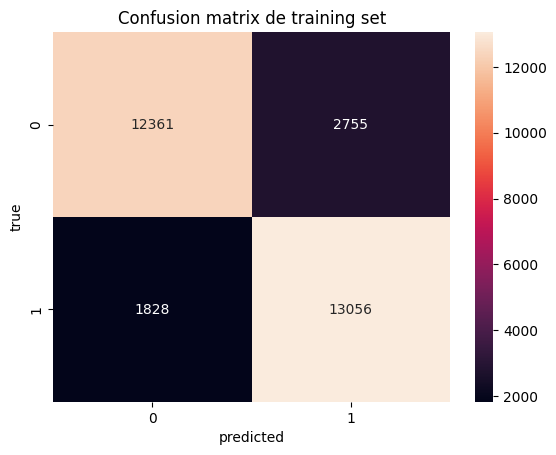

In [40]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de training set")

In [41]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(rf_cv_best.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

Guardamos el modelo para ser usado mas tarde en el ensamble

In [128]:
with open('modelos/RandomForestCV.pickle', 'wb') as file:
    pickle.dump(rf_cv_best, file)

### XGBoost

In [46]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [47]:
vectorizador = CountVectorizer()
escaladorTfidf = TfidfTransformer()
X_train_counts_1 = vectorizador.fit_transform(X_train)
X_train_tfidf_1 = escaladorTfidf.fit_transform(X_train_counts_1)
X_test_counts_1 = vectorizador.transform(X_test)
X_test_tfidf_1 = escaladorTfidf.transform(X_test_counts_1)


In [48]:
d_train = xgb.DMatrix(X_train_tfidf_1, label=y_train)
d_test = xgb.DMatrix(X_test_tfidf_1, label=y_test)

In [ ]:
clf = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000, early_stopping_rounds=50)

clf.fit(X_train_tfidf_1, y_train,
       eval_set=[(X_train_tfidf_1, y_train), (X_test_tfidf_1, y_test)],
       verbose=50)

[0]	validation_0-logloss:0.67379	validation_1-logloss:0.67467
[50]	validation_0-logloss:0.44841	validation_1-logloss:0.48307
[100]	validation_0-logloss:0.37940	validation_1-logloss:0.43327
[150]	validation_0-logloss:0.33638	validation_1-logloss:0.40626
[200]	validation_0-logloss:0.30557	validation_1-logloss:0.38813
[250]	validation_0-logloss:0.28090	validation_1-logloss:0.37476
[300]	validation_0-logloss:0.26092	validation_1-logloss:0.36480
[350]	validation_0-logloss:0.24460	validation_1-logloss:0.35689
[400]	validation_0-logloss:0.22972	validation_1-logloss:0.35017
[450]	validation_0-logloss:0.21787	validation_1-logloss:0.34477
[500]	validation_0-logloss:0.20686	validation_1-logloss:0.33987
[550]	validation_0-logloss:0.19707	validation_1-logloss:0.33619
[600]	validation_0-logloss:0.18799	validation_1-logloss:0.33256
[650]	validation_0-logloss:0.17969	validation_1-logloss:0.32937
[700]	validation_0-logloss:0.17271	validation_1-logloss:0.32663
[750]	validation_0-logloss:0.16597	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, clf.predict(X_test_tfidf_1)))
print("f1 score sobre train: ", f1_score(y_train, clf.predict(X_train_tfidf_1)))

f1 score sobre validacion:  0.8629673826571201
f1 score sobre train:  0.9805899661251638


In [ ]:
clf2 = xgb.XGBClassifier(learning_rate=0.1,
                         max_depth=10,
                         subsample=0.8,
                         reg_lambda = 4,
                         reg_alpha = 3,
                         nthread = -1,
                         n_estimators=1000, early_stopping_rounds=50)

clf2.fit(X_train_tfidf_1, y_train,
       eval_set=[(X_train_tfidf_1, y_train), (X_test_tfidf_1, y_test)],
       verbose=50)

[0]	validation_0-logloss:0.66882	validation_1-logloss:0.67042
[50]	validation_0-logloss:0.39136	validation_1-logloss:0.44845
[100]	validation_0-logloss:0.31287	validation_1-logloss:0.39965
[150]	validation_0-logloss:0.26653	validation_1-logloss:0.37553
[200]	validation_0-logloss:0.23447	validation_1-logloss:0.35980
[250]	validation_0-logloss:0.20990	validation_1-logloss:0.34838
[300]	validation_0-logloss:0.18886	validation_1-logloss:0.34061
[350]	validation_0-logloss:0.17235	validation_1-logloss:0.33435
[400]	validation_0-logloss:0.15860	validation_1-logloss:0.33024
[450]	validation_0-logloss:0.14577	validation_1-logloss:0.32639
[500]	validation_0-logloss:0.13424	validation_1-logloss:0.32381
[550]	validation_0-logloss:0.12450	validation_1-logloss:0.32132
[600]	validation_0-logloss:0.11566	validation_1-logloss:0.32008
[650]	validation_0-logloss:0.10804	validation_1-logloss:0.31955
[700]	validation_0-logloss:0.10019	validation_1-logloss:0.31919
[714]	validation_0-logloss:0.09841	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=-1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, clf2.predict(X_test_tfidf_1)))
print("f1 score sobre train: ", f1_score(y_train, clf2.predict(X_train_tfidf_1)))

f1 score sobre validacion:  0.8564593301435406
f1 score sobre train:  0.9852050441862775


In [ ]:
clf3 = xgb.XGBClassifier(learning_rate=0.1,
                         max_depth=14,
                         subsample=0.9,
                         gamma = 7,
                         reg_lambda = 4,
                         reg_alpha = 3,
                         nthread = -1,
                         n_estimators=800, early_stopping_rounds=50)

clf3.fit(X_train_tfidf_1, y_train,
       eval_set=[(X_train_tfidf_1, y_train), (X_test_tfidf_1, y_test)],
       verbose=50)

[0]	validation_0-logloss:0.66579	validation_1-logloss:0.66877
[50]	validation_0-logloss:0.38087	validation_1-logloss:0.43420
[100]	validation_0-logloss:0.32384	validation_1-logloss:0.39058
[150]	validation_0-logloss:0.29430	validation_1-logloss:0.36886
[200]	validation_0-logloss:0.27395	validation_1-logloss:0.35389
[250]	validation_0-logloss:0.25829	validation_1-logloss:0.34417
[300]	validation_0-logloss:0.24883	validation_1-logloss:0.33855
[350]	validation_0-logloss:0.24543	validation_1-logloss:0.33679
[400]	validation_0-logloss:0.24399	validation_1-logloss:0.33587
[450]	validation_0-logloss:0.24286	validation_1-logloss:0.33528
[500]	validation_0-logloss:0.24198	validation_1-logloss:0.33488
[550]	validation_0-logloss:0.24127	validation_1-logloss:0.33457
[600]	validation_0-logloss:0.24073	validation_1-logloss:0.33433
[650]	validation_0-logloss:0.23972	validation_1-logloss:0.33389
[700]	validation_0-logloss:0.23892	validation_1-logloss:0.33333
[750]	validation_0-logloss:0.23801	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, clf3.predict(X_test_tfidf_1)))
print("f1 score sobre train: ", f1_score(y_train, clf3.predict(X_train_tfidf_1)))

f1 score sobre validacion:  0.852952913008779
f1 score sobre train:  0.9214765265720679


In [53]:
param_grid = {
'learning_rate': [0.01, 0.1, 0.2],
'max_depth': [3, 5, 7, 10],
'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
'reg_lambda': [0.1, 1, 10],
'reg_alpha': [0.1, 1, 10],
'n_estimators': [100, 500, 1000]
}

xgb_clf = xgb.XGBClassifier()

grid = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, cv=3, n_iter=10, scoring=make_scorer(f1_score), n_jobs = -1)
grid.fit(X_train_tfidf_1, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
grid.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.1,
 'reg_alpha': 1,
 'n_estimators': 500,
 'max_depth': 5,
 'learning_rate': 0.2}

In [55]:
y_pred = grid.predict(X_test_tfidf_1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

F1 Score: 0.8518310231896523
Precision: 0.8390355164548713
Recall: 0.8650228433216878
Accuracy: 0.8507


Text(0.5, 1.0, 'Confusion matrix de training set')

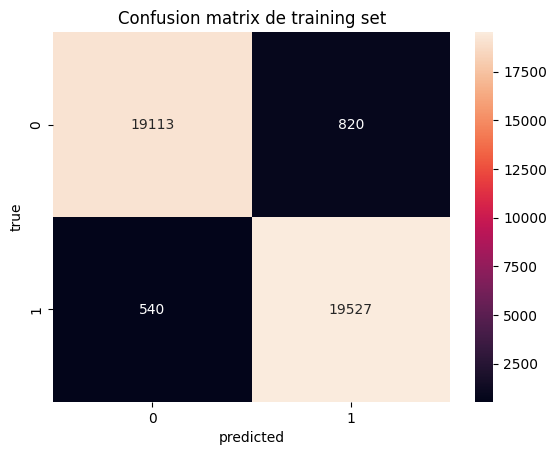

In [ ]:
y_pred = grid.predict(X_train_tfidf_1)
confusion = confusion_matrix(y_train, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de training set")

In [ ]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(grid.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')
assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

In [57]:
with open('modelos/XgBoostCV.pickle', 'wb') as file:
    pickle.dump(grid, file)

### Red neuronal con Keras y TensorFlow

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [51]:
max_words = 50

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_words)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_words)

In [55]:
model = Sequential()

model.add(Embedding(len(tokenizer.word_index) + 1, 64, input_length=max_words,trainable=True))
model.add(LSTM(units = 60, activation="relu", kernel_regularizer="l2", return_sequences = False,recurrent_dropout=0.2))
model.add(Dense(20, activation="relu", kernel_regularizer = "l2"))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 64)            8459968   
                                                                 
 lstm_9 (LSTM)               (None, 60)                30000     
                                                                 
 dense_18 (Dense)            (None, 20)                1220      
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 8,491,209
Trainable params: 8,491,209
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
model.fit(X_train_padded, y_train, epochs=15, callbacks = EarlyStopping(monitor='loss', patience=3))

Epoch 1/15
1205/1205 [==============================] - 231s 190ms/step - loss: 0.7237 - accuracy: 0.6799
Epoch 2/15
1205/1205 [==============================] - 228s 189ms/step - loss: 0.9313 - accuracy: 0.7651
Epoch 3/15
1205/1205 [==============================] - 249s 206ms/step - loss: 0.4425 - accuracy: 0.8693
Epoch 4/15
1205/1205 [==============================] - 241s 200ms/step - loss: 0.2556 - accuracy: 0.9270
Epoch 5/15
1205/1205 [==============================] - 237s 197ms/step - loss: 0.1712 - accuracy: 0.9569
Epoch 6/15
1205/1205 [==============================] - 237s 197ms/step - loss: 0.1166 - accuracy: 0.9748
Epoch 7/15
1205/1205 [==============================] - 246s 204ms/step - loss: 0.0815 - accuracy: 0.9844
Epoch 8/15
1205/1205 [==============================] - 238s 198ms/step - loss: 0.0641 - accuracy: 0.9890
Epoch 9/15
1205/1205 [==============================] - 227s 189ms/step - loss: 0.0477 - accuracy: 0.9924
Epoch 10/15
1205/1205 [=======================

In [58]:
y_pred = np.where(model.predict(X_test_padded) >= 0.5, 1, 0)

302/302 [==============================] - 2s 5ms/step


Text(0.5, 1.0, 'Confusion matrix de validación')

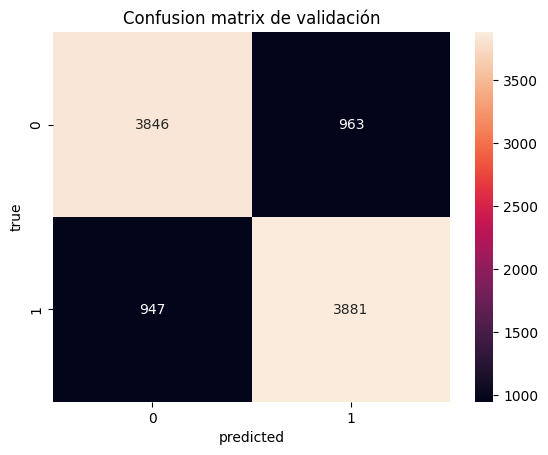

In [59]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

In [60]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8018055411435094
Precision: 0.8011973575557391
Recall: 0.8038525269262634
F1-score: 0.802522746071133


In [62]:
with open('modelos/NN.pickle', 'wb') as file:
    pickle.dump(model, file)

In [61]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test.review_es
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_words)
    
prediccion = np.where(model.predict(X_padded) >= 0.5, 'positivo', 'negativo').reshape(-1)
assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

269/269 [==============================] - 1s 5ms/step


### Ensamble de modelos

In [118]:
from sklearn.ensemble import VotingClassifier

In [129]:
bn = pickle.load(open('modelos/BayesNaiveCV.pickle', 'rb'))
rf = pickle.load(open('modelos/RandomForestCV.pickle', 'rb'))
xgb = pickle.load(open('modelos/XgBoostCV.pickle', 'rb'))

In [132]:
voting = VotingClassifier(estimators=[ ('rf', rf),('xgb', xgb),('bn', bn)], voting='hard')

In [125]:
X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=19)
vectorizador = CountVectorizer()
escaladorTfidf = TfidfTransformer()
X_train_counts_3 = vectorizador.fit_transform(X_train)
X_train_tfidf_3 = escaladorTfidf.fit_transform(X_train_counts_3)
X_test_counts_3 = vectorizador.transform(X_test)
X_test_tfidf_3 = escaladorTfidf.transform(X_test_counts_3)

In [133]:
voting.fit(X_train_tfidf_3, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     min_samples_leaf=10,
                                                     n_estimators=300)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gp...
       0.47948718, 0.4974359 , 0.51538462, 0.53333333, 0.55128205,
       0.56923077, 0.58717949, 0.60512821, 0.62307692, 0.64102564,
       0.65897436, 0.67692308, 0.69487179, 0.71282051, 0.73076923,
       0.74871795, 0.76666667, 0.78461538, 0.8025641 , 0.82051282,
       0.83846154, 0.85641026, 0.87435897, 0.89230769, 0.91025641,
       0.92820513, 0.94615385, 0.96410256, 0.98205128, 1.        ])},
                                           scoring=make_scorer(f1_score)))])

In [134]:
print("f1 score sobre validacion con el ensamble de voting: ", f1_score(y_test, voting.predict(X_test_tfidf_3)))
print("f1 score sobre train con el modelo de voting: ", f1_score(y_train, voting.predict(X_train_tfidf_3 )))

f1 score sobre validacion con el ensamble de voting:  0.866429089949185
f1 score sobre train con el modelo de voting:  0.9566029390082076


Ploteamos matriz de confusion sobre el conjunto de validacion

Text(0.5, 1.0, 'Confusion matrix del validation set (voting)')

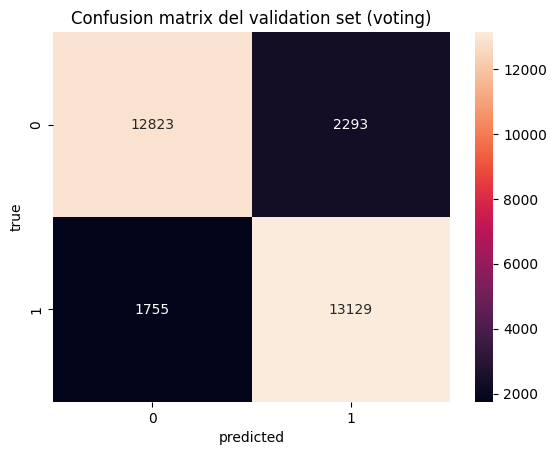

In [135]:
y_pred = voting.predict(X_test_tfidf_3)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix del validation set (voting)")

Creamos submit para competencia Kaggle

In [136]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(rf_cv_best.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

Guardamos modelo con pickle

In [74]:
with open('modelos/Voting.pickle', 'wb') as file:
    pickle.dump(voting, file)